In [41]:
import logging
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor
from matplotlib import pyplot as plt
import numpy as np
import math
import json
import os
from copy import deepcopy, copy
from nim_utils import *

logging.basicConfig(
    format="[%(asctime)s] %(levelname)s: %(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

In [42]:
class Agent():
    def __init__(self, nim, alpha = 0.1, random_factor = 0.2) -> None:
        self.state_history = []
        self.alpha = alpha
        self.random_factor = random_factor
        # Q table, initially empty
        self.Q = {}
        self.init_q(nim)

    def init_q(self, nim) -> dict:
        result = []
        def generate_states(rows, current_state):
            if len(current_state) == len(rows):
                # We have generated a valid state 
                result.append(current_state)
                return
            # Generate all possible states for the current row
            for i in range(rows[len(current_state)] + 1):
                new_state = current_state + [i]
                generate_states(rows, new_state)
        
        generate_states(nim.rows, [])
        for state in result:
            x = Nim(len(nim.rows), state=state)
            for action in x.possible_moves():
                self.Q[(x, action)] = np.random.uniform(low=1.0, high=0.1)     

    def choose_action(self, state) -> Nimply:
        maxG = -10e15
        next_move = None
        possible_moves = state.possible_moves()
        if np.random.random() < self.random_factor:
            next_move = random.choice(possible_moves) 
        else:
            for action in possible_moves:
                # print(f"Check {new_state}")
                if self.Q[(state, action)] >= maxG:
                    next_move = action
                    maxG = self.Q[(state, action)]
        return next_move

    def update_state_history(self, state, action,  reward):
        self.state_history.append(((state, action), reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            state, action = prev
            # print(f"{state} {action}")
            self.Q[prev] = self.Q[prev] + self.alpha * (target - self.Q[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play

    def get_strategy(self) -> Callable:
        def agent_strategy(state: Nim) -> Nimply:
            action = self.choose_action(state)
            # print(f"Choosen action: {action}")
            return Nimply(action[0], action[1])
        return agent_strategy

### Reinforcement learning strategies


In [43]:
# Costants
NUM_EPOCHS = 5000
EVALUATION_RATE = 100
NIM_SIZE = 5
MASK = [0, 0, 0, 1]
POSSIBLE_OPPONENTS = [gabriele, pure_random, aggressive, optimal_strategy]
OPPONENTS = [el for sublist in [alpha*[opponent] for alpha, opponent in zip(MASK, POSSIBLE_OPPONENTS)] for el in sublist]

In [44]:
# Create the agent and the game
game = Nim(NIM_SIZE)
agent = Agent(game)

In [45]:
print(f"I have generated {len(agent.Q)} states-action pair.")
# for state in agent.Q:
#     print(f"{state[0]}, {state[1]}: {agent.Q[state]}")

I have generated 28247 states-action pair.


In [46]:
scores = []

for i in range(NUM_EPOCHS):
    # logging.debug(f"Starting the game #{i}")
    current_game = Nim(NIM_SIZE)
    opponent = optimal_strategy
    turn = True
    while current_game:
        if turn:
            state, _ = current_game.get_state_and_reward(turn)
            # my agent turn
            action = agent.choose_action(current_game)
            # print(f"Action: {action}")
            current_game.nimming(action)
            _, reward = current_game.get_state_and_reward(turn)
            # print(f"{state} -> {reward}")
            agent.update_state_history(state, action, reward)
        else:
            action = opponent(current_game)
            current_game.nimming(action)
        turn = not turn
    winner = int(turn)
    # logging.debug(f"The game ended. Player {winner} wins")
    agent.learn()
    if i % EVALUATION_RATE == 0:
        score = evaluate_against(agent.get_strategy(), opponent, NIM_SIZE=NIM_SIZE)
        scores.append(score)
        print(f"#{i}: {score}")

#0: 0.0
#100: 0.0
#200: 0.0
#300: 0.0
#400: 0.0
#500: 0.0
#600: 0.08
#700: 0.05
#800: 0.0
#900: 0.0
#1000: 0.03
#1100: 0.04
#1200: 0.05
#1300: 0.06
#1400: 0.03
#1500: 0.12
#1600: 0.05
#1700: 0.06
#1800: 0.08
#1900: 0.08
#2000: 0.14
#2100: 0.13
#2200: 0.02
#2300: 0.06
#2400: 0.11
#2500: 0.08
#2600: 0.24
#2700: 0.17
#2800: 0.25
#2900: 0.23
#3000: 0.34
#3100: 0.38
#3200: 0.32
#3300: 0.41
#3400: 0.4
#3500: 0.45
#3600: 0.47
#3700: 0.49
#3800: 0.46
#3900: 0.47
#4000: 0.45
#4100: 0.43
#4200: 0.43
#4300: 0.34
#4400: 0.43
#4500: 0.42
#4600: 0.49
#4700: 0.4
#4800: 0.45
#4900: 0.44


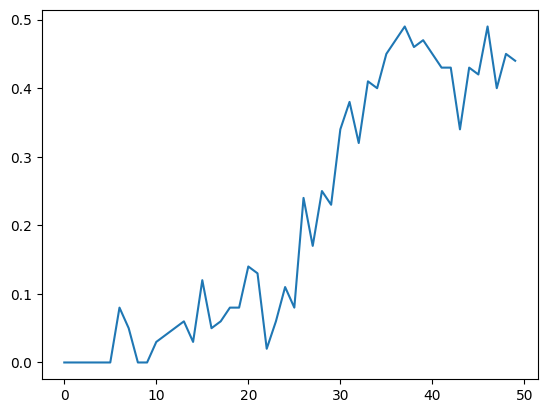

In [47]:
plt.plot(range(len(scores)), scores)
plt.show()

### Evaluation

In [50]:
rl_strategy = agent.get_strategy()
OPPONENTS = [gabriele, pure_random, aggressive, optimal_strategy]

scores = [(opponent.__name__, evaluate_against(rl_strategy, opponent, NIM_SIZE=NIM_SIZE)) for opponent in OPPONENTS]

for opponent, score in scores:
    print(f"rl vs. {opponent}: {score}") 

rl vs. gabriele: 0.0
rl vs. pure_random: 0.69
rl vs. aggressive: 0.82
rl vs. optimal_strategy: 0.47
